Current error: 1.3638079012812616
Current number of layers: 0
Current error: 1.3638079012812616
Current number of layers: 0


/workspaces/QCproject/.venv/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Full statevector:
 Statevector([ 0.07001402+1.34776661e-06j,  0.14002804+1.07821327e-05j,
              0.21004205+3.63896967e-05j,  0.28005604+8.62570546e-05j,
              0.35007001+1.68470799e-04j,  0.42008393+2.91117515e-04j,
              0.49009779+4.62283781e-04j,  0.56011156+6.90056158e-04j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00

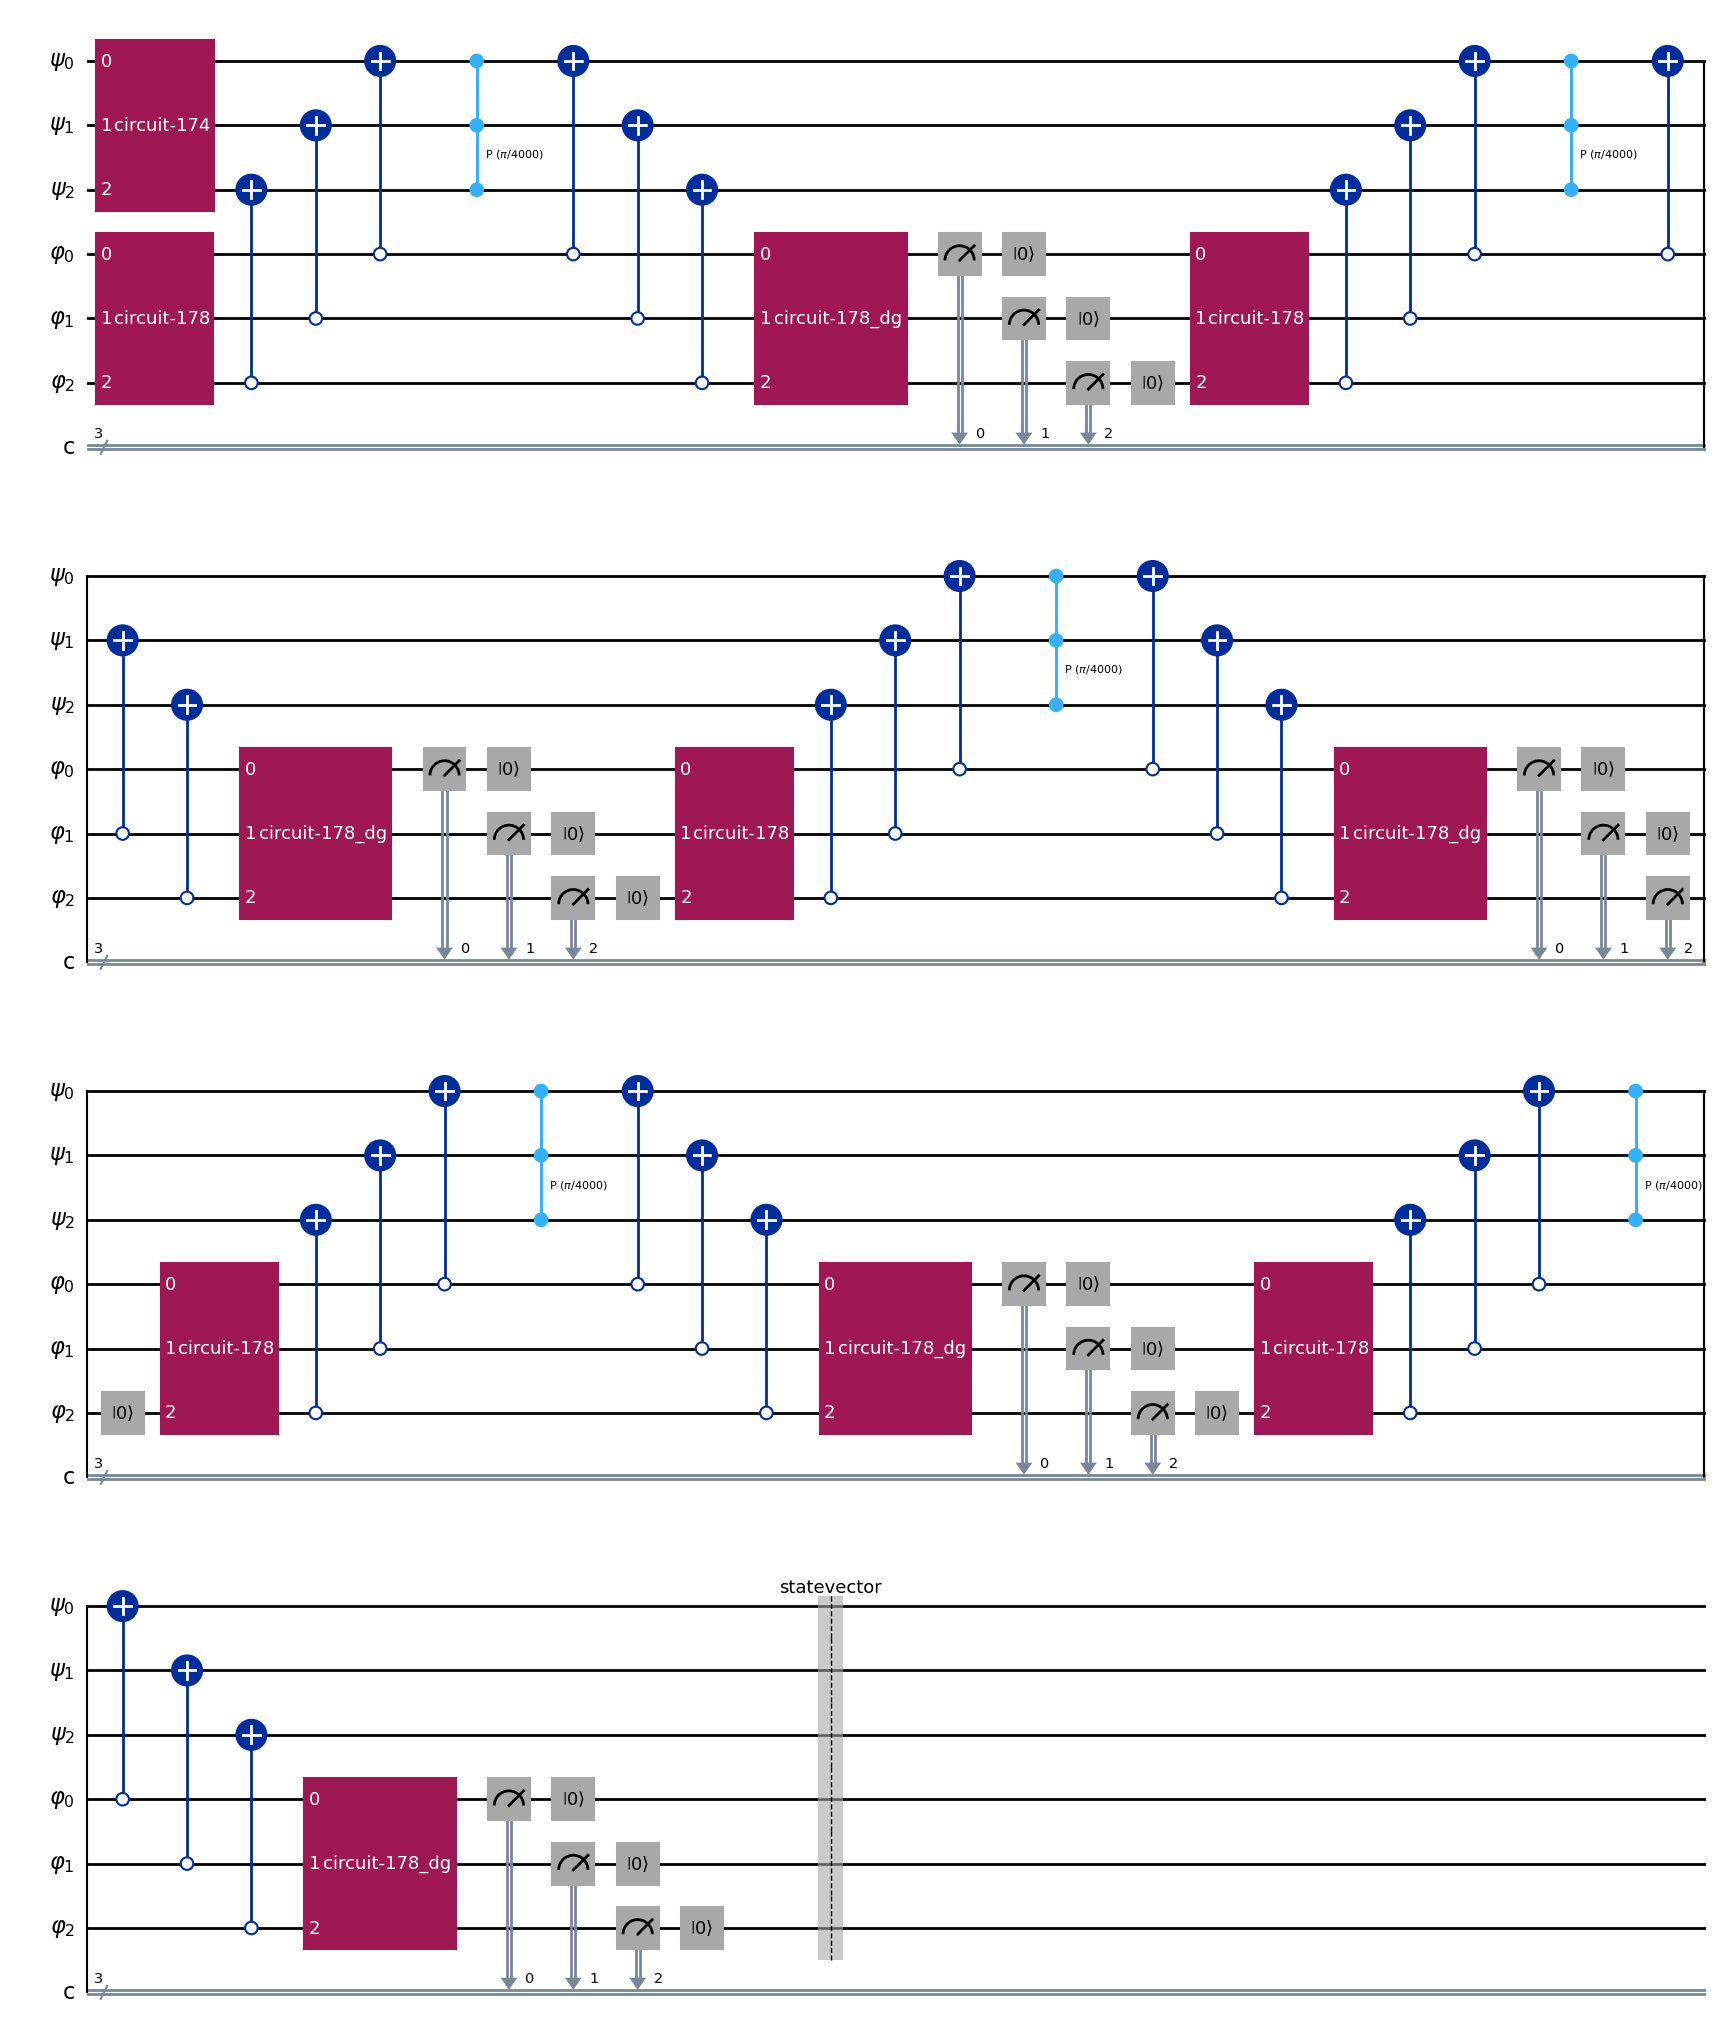

In [2]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity


psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3  
m = 5
delta = np.pi / 4 / 1000 # Phase to be added
number_of_layers = 2

psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)

U_phi_dagger = U_phi.inverse()

psi_reg = QuantumRegister(n, name="ψ")
phi_reg = QuantumRegister(n, name="φ")
creg = ClassicalRegister(n, name="c")
qc = QuantumCircuit(psi_reg, phi_reg, creg)

#for psi
qc.append(U_psi, psi_reg)

#for phi
qc.append(U_phi, phi_reg)

# bit matching
for k in range(1, m+1):
    # --- mark (CNOTs using ctrl_state=0) ---
    for i in range(n):
        qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

    # --- apply small phase ---
    qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

    # --- uncompute the flags ---
    for i in range(n):
        qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

    # --- uncompute U_phi, measure φ, reset φ ---
    qc.append(U_phi_dagger, phi_reg)
    qc.measure(phi_reg, creg)   # measure program register (partial measurement)
    qc.reset(phi_reg)           # reset φ to |0...0>

   

    if k < m:
        qc.append(U_phi, phi_reg)


qc.save_statevector()

#simulate
sim = AerSimulator()
result = sim.run(transpile(qc, sim)).result()

# Full statevector
full = result.get_statevector(qc)

rho_psi = partial_trace(full, list(range(n, 2*n)))

print("Full statevector:\n", full)

# Measurement Z

probabilities = full.probabilities_dict()
print("\nMeasurement prob:", probabilities)

# Plot histogram
plot_histogram(probabilities)
plt.show()


qc.draw('mpl')


In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

psi_vec = np.array(psi, dtype=complex) / np.linalg.norm(psi)
phi_vec = np.array(phi, dtype=complex) / np.linalg.norm(phi)
phase_profile = np.exp(1j * delta * np.abs(phi_vec)**2)
ideal_vec = psi_vec * phase_profile
ideal_rho = DensityMatrix(ideal_vec)  # density matrix of ideal ψ

# ------------------------
# Fidelity and error
# ------------------------
fidelity = state_fidelity(rho_psi, ideal_rho)
error = 1 - fidelity

print("Fidelity:", fidelity)
print("Error:", error)


Fidelity: 0.999999918891653
Error: 8.110834703867198e-08


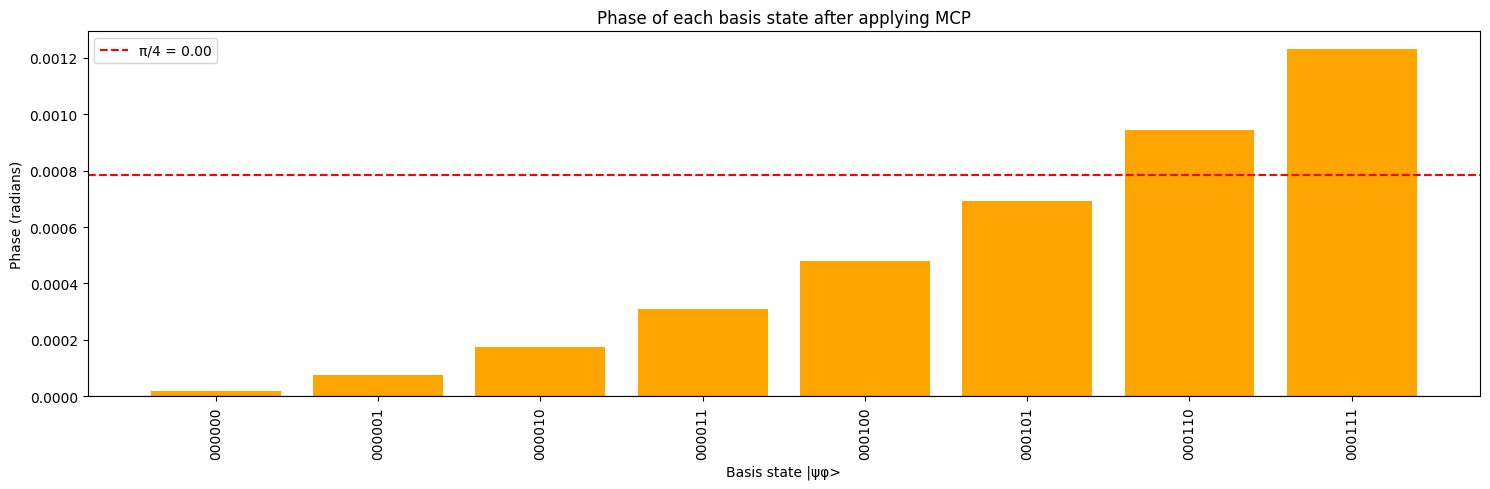

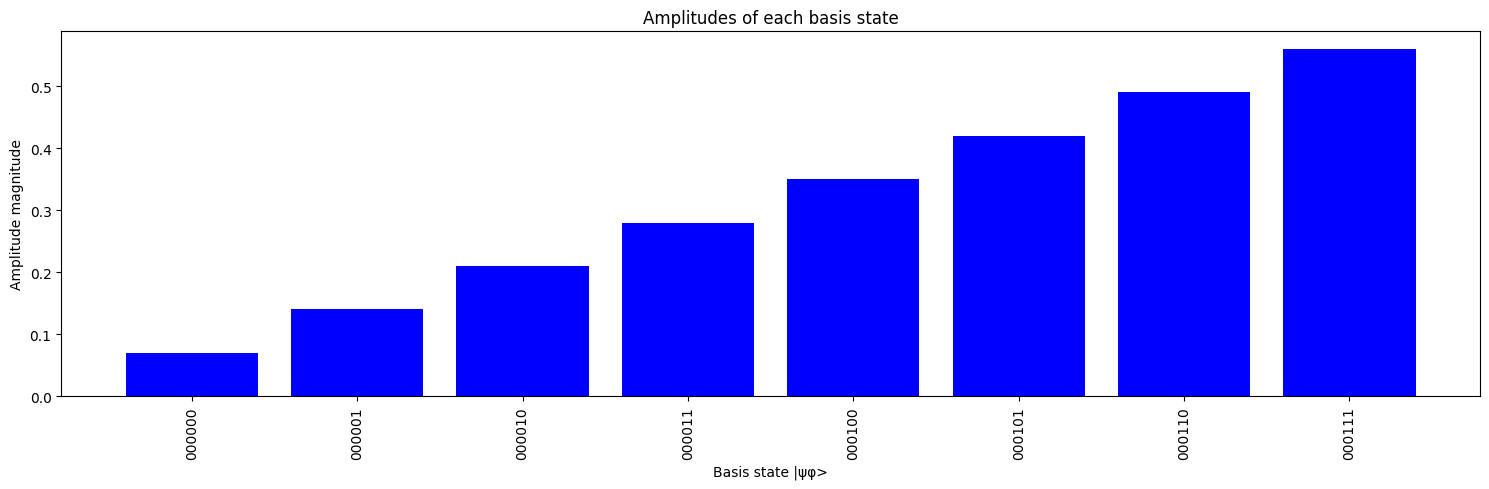

In [4]:
# Get amplitudes and phases
amps = np.abs(full)
phases = np.angle(full)

# Create basis labels
basis_labels = [format(i, f'0{n*2}b') for i in range(len(amps))]

# Plot phases vs basis states
plt.figure(figsize=(15,5))
plt.bar(basis_labels[0:8], phases[0:8], color='orange')
plt.axhline(delta, color='red', linestyle='--', label=f'π/4 = {delta:.2f}')
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Phase (radians)")
plt.xlabel("Basis state |ψφ>")
plt.xticks(rotation=90)
plt.title("Phase of each basis state after applying MCP")

plt.legend()
plt.tight_layout()
plt.show()

# Plot amplitudes separately (optional)
plt.figure(figsize=(15,5))
plt.bar(basis_labels[0:8], amps[0:8], color='blue')
plt.ylabel("Amplitude magnitude")
plt.xlabel("Basis state |ψφ>")
plt.title("Amplitudes of each basis state")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
